# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Reproducibility
## Chapter : Curvature penalized models

In this notebook, we solve non-holonomic eikonal equations on the CPU and GPU, related to curvature penalized models.
Our purpose is to establish that the schemes produce consistent results.

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"../..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Rander_Repro','GPU'))

In [2]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [3]:
from agd import HFMUtils
from agd import AutomaticDifferentiation as ad
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
import agd.AutomaticDifferentiation.cupy_generic as cugen

norm_infinity = ad.Optimization.norm_infinity
from Notebooks_GPU.ExportedCode.Isotropic_Repro import RunCompare

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,RunGPU,RunSmart,Metrics
    HFMUtils,ad,cugen,Metrics = rreload([HFMUtils,ad,cugen,Metrics],"../..")    
    HFMUtils.dictIn.RunSmart = cugen.cupy_get_args(HFMUtils.RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

In [5]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
HFMUtils.dictIn.RunSmart = cugen.cupy_get_args(HFMUtils.RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

In [110]:
from agd.HFMUtils.HFM_CUDA import inf_convolution
from Miscellaneous.rreload import rreload
(inf_convolution,) = rreload((inf_convolution,),'../..')

In [111]:
ndim=2
kernel = inf_convolution.distance_kernel(radius=1,ndim=ndim,dtype=np.uint8,mult=5)
arr = cp.full((10,)*ndim,255,dtype=np.uint8)
out = inf_convolution.inf_convolution(arr,kernel,niter=4,upper_saturation=255)
arr[5,5]=0
print(kernel,arr,out)


[[255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]]
[[255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]]
[[255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255

In [ ]:
inf_convolution.inf_convolution(

## 1. Reeds-Shepp

In [92]:
ReloadPackages()

In [93]:
n=100; nTheta=60
hfmIn = HFMUtils.dictIn({
    'model':'Dubins2',
    'seeds':cp.array([[0.,0.,np.pi]]),
    'exportValues':1,
    'cost':1,
    'xi':0.4,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
hfmIn['dims'] = np.append(hfmIn['dims'],nTheta)
        
tips = hfmIn.Grid(dims=(4,4,4))
tips = np.moveaxis(tips.reshape(3,-1),0,-1)
hfmIn['tips'] = tips

Casting output of function array from float64 to float32


In [94]:
hfmOut = hfmIn.RunGPU()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.23999905586242676 seconds,  and 72 iterations.
Post-Processing


In [95]:
np.sum(hfmOut['seedTags'])

array(1)

In [96]:
hfmOut['seedTags'].shape,hfmOut['eucl'].shape


((101, 101, 60), (101, 101, 60))

In [97]:
hfmOut['eucl_kernel']

array([[[9, 7, 9],
        [7, 5, 7],
        [9, 7, 9]],

       [[7, 5, 7],
        [5, 0, 5],
        [7, 5, 7]],

       [[9, 7, 9],
        [7, 5, 7],
        [9, 7, 9]]], dtype=uint8)

In [98]:
hfmOut['eucl'][:,:,30]

array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, ..., 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, ...,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, ...,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 

In [53]:
hfmOut['values'].shape
#hfmOut['geodesics']

(101, 101, 60)

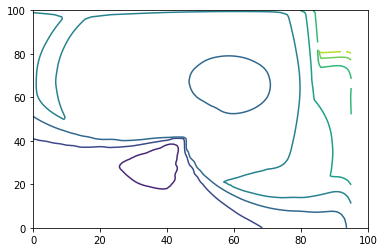

In [67]:
plt.contour(hfmOut['values'][:,:,40])

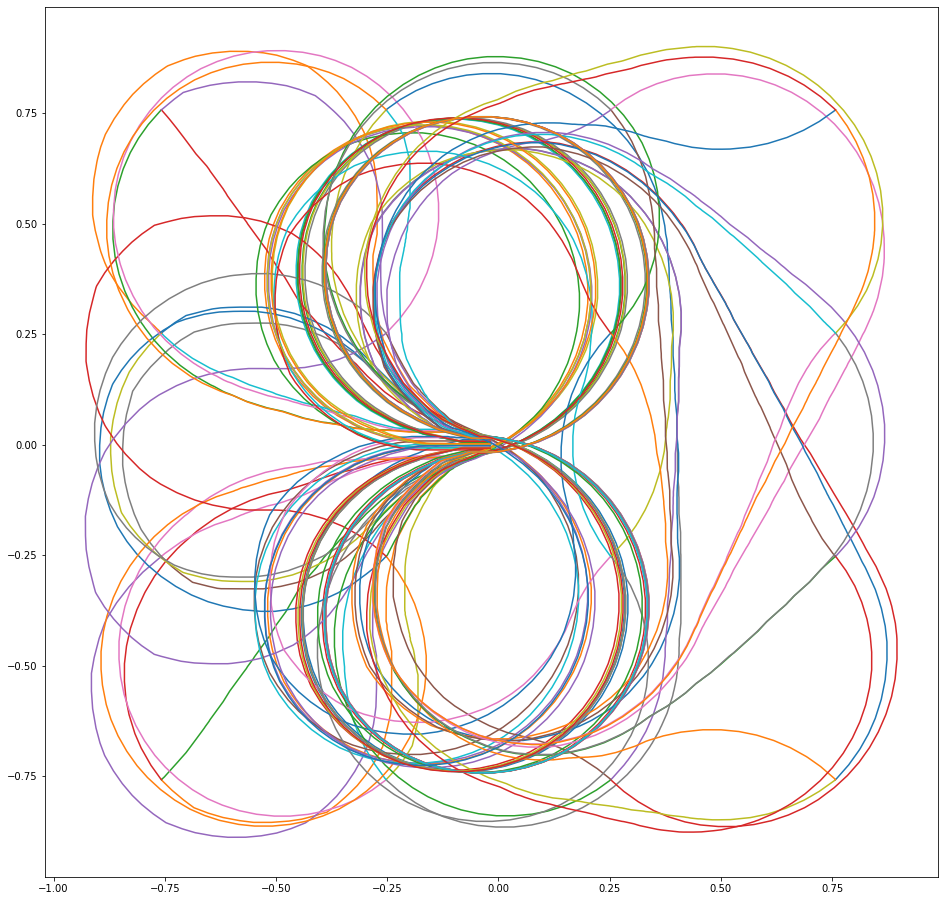

In [68]:
plt.figure(figsize=[16,16])
for geo in hfmOut['geodesics']: plt.plot(geo[0],geo[1])

## 2. Reeds-Shepp forward

In [17]:
n=20; nTheta=60
hfmIn = HFMUtils.dictIn({
    'model':'ReedsSheppForward2',
    'seeds':cp.array([[0.,0.,np.pi]]),
    'exportValues':1,
    'cost':1,
    'xi':0.2,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
hfmIn['dims'] = np.append(hfmIn['dims'],nTheta)

Casting output of function array from float64 to float32


In [18]:
RunGPU(hfmIn)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the values array (setting seeds,...)


ValueError: Inconsistent type <class 'numpy.object_'> for key geom

In [ ]:
np.append